<a href="https://colab.research.google.com/github/nidhaloff/FashionMNIST/blob/master/FashionMnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.optim as optim

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]))

#loader declaration
train_loader = DataLoader(dataset=trainset, batch_size=100, shuffle=True)
test_loader = DataLoader(dataset=testset, batch_size=100, shuffle=False)

In [0]:
# temp = next(iter(train_loader))
# image, label = temp
# print(image[0].shape)

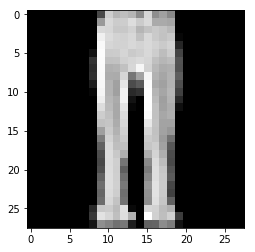

In [147]:
#fig = plt.figure(figsize=(2,2))
#fig.add_subplot(111)
plt.imshow(image[2][0], cmap='gray')
plt.show()

In [0]:
# custom class neural network 
class FashionMnistClassifier(nn.Module):
  def __init__(self, n_inputs, n_out):
    super().__init__()
    self.cnn1 = nn.Conv2d(n_inputs, out_channels=32, kernel_size=5).cuda(device)
    self.cnn2 = nn.Conv2d(32, out_channels=64, kernel_size=5).cuda(device)
    #self.cnn3 = nn.Conv2d(n_inputs, out_channels=32, kernel_size=5)
    self.fc1 = nn.Linear(64*4*4, out_features=1000).cuda(device)
    self.fc2 = nn.Linear(1000, out_features=800).cuda(device)
    self.fc3 = nn.Linear(800, out_features=300).cuda(device)
    self.fc4 = nn.Linear(300, out_features=100).cuda(device)
    self.fc5 = nn.Linear(100, out_features=n_out).cuda(device)
    self.relu = nn.ReLU().cuda(device)
    self.pool = nn.MaxPool2d(kernel_size=2).cuda(device)
    self.soft_max = nn.Softmax().cuda(device)

  def forward(self, x):
    x.cuda(device)
    out = self.relu(self.cnn1(x))
    out = self.pool(out)
    out = self.relu(self.cnn2(out))
    out = self.pool(out)
    #print("out shape in classifier forward func: ", out.shape)
    out = self.fc1(out.view(out.size(0), -1))
    out = self.relu(out)
    out = self.fc2(out)
    out = self.relu(out)
    out = self.fc3(out)
    out = self.relu(out)
    out = self.fc4(out)
    out = self.relu(out)
    out = self.fc5(out)
    return out

n_batch = 100
n_outputs = 10
LR = 0.001

model = FashionMnistClassifier(1, 10).cuda(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [0]:

def train(epochs=20):
  loss_list, iters, accuracy_list, count = [], [], [], 0
  model.train()
  for epoch in range(epochs):
    for image, label in train_loader:
      image = torch.autograd.Variable(image.view(n_batch, 1, 28, 28)).to(device)
      label = torch.autograd.Variable(label).to(device)
      optimizer.zero_grad()
      out = model(image)
      #print(out.shape, label.shape)
      loss = criterion(out, label)
      loss.backward()
      optimizer.step()
      count += 1
      
      if count % 50 == 0:
        #model.eval()
        correct, total = 0, 0
        for image, label in test_loader:
          image = torch.autograd.Variable(image.view(n_batch, 1, 28, 28)).to(device)
          label = torch.autograd.Variable(label).to(device)
          out = model(image)
          loss = criterion(out, label)
          pred = torch.max(out.data, 1)[1]
          total += len(label)
          correct += (pred == label).sum()

        accuracy = 100 * correct / total
        iters.append(count)
        loss_list.append(loss.data)
        accuracy_list.append(accuracy)
      
      if count % 500 == 0:
        print(f"iteration: {count} - the loss= {loss.data} - Accuracy= {accuracy} %")
  return loss_list, iters, accuracy_list

iteration: 500 - the loss= 0.4418928027153015 - Accuracy= 84 %
iteration: 1000 - the loss= 0.3241720199584961 - Accuracy= 88 %
iteration: 1500 - the loss= 0.3534383475780487 - Accuracy= 89 %
iteration: 2000 - the loss= 0.2709585130214691 - Accuracy= 89 %
iteration: 2500 - the loss= 0.2755008935928345 - Accuracy= 90 %
iteration: 3000 - the loss= 0.29856276512145996 - Accuracy= 90 %
iteration: 3500 - the loss= 0.3045240640640259 - Accuracy= 89 %
iteration: 4000 - the loss= 0.2235337644815445 - Accuracy= 89 %
iteration: 4500 - the loss= 0.2626011371612549 - Accuracy= 90 %
iteration: 5000 - the loss= 0.29260388016700745 - Accuracy= 89 %
iteration: 5500 - the loss= 0.3214911222457886 - Accuracy= 91 %
iteration: 6000 - the loss= 0.33576565980911255 - Accuracy= 90 %
iteration: 6500 - the loss= 0.2286333441734314 - Accuracy= 91 %
iteration: 7000 - the loss= 0.3886357247829437 - Accuracy= 90 %
iteration: 7500 - the loss= 0.4858529567718506 - Accuracy= 91 %
iteration: 8000 - the loss= 0.46684607

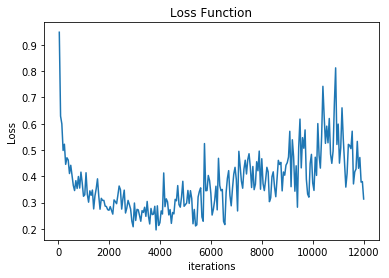

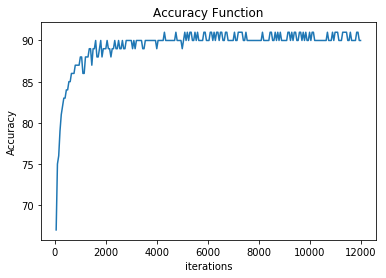

In [153]:

loss, iters, acc = train()
plt.plot(iters, loss)
plt.title("Loss Function")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.show()

plt.plot(iters, acc)
plt.title("Accuracy Function")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.show()